<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/03_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook

In [7]:
from datasets import load_dataset

import torch
import torchsummary
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader

import matplotlib as mpl
from matplotlib import pyplot as plt

from genaibook.core import show_images
from genaibook.core import get_device

from tqdm.notebook import tqdm, trange

import requests
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from transformers import pipeline
from genaibook.core import SampleURL

import pandas as pd
import numpy as np

In [3]:
device = get_device()

## Dataset

In [ ]:
mnist = load_dataset("mnist")

In [ ]:
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
mnist["train"]["image"][1]

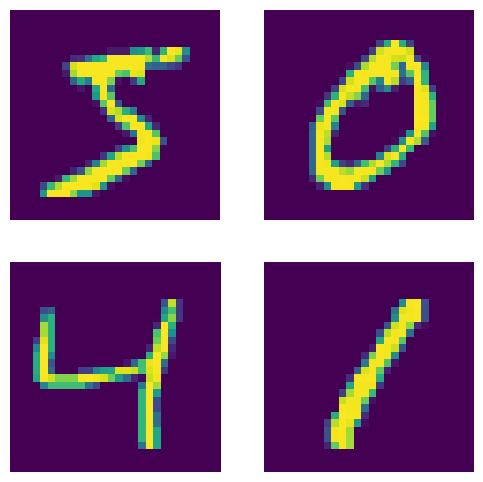

In [ ]:
# let's show them with higher resolution
show_images(mnist["train"]["image"][:4])

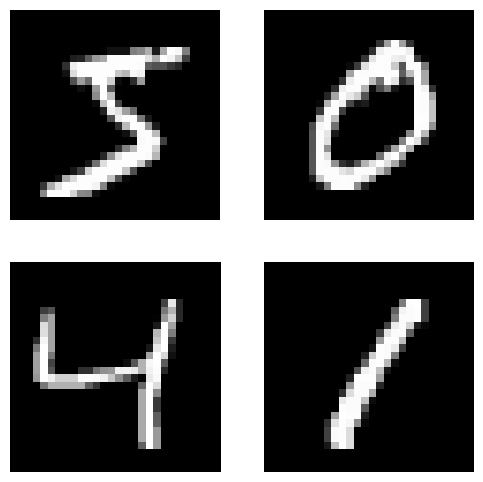

In [ ]:
# let's configure matplotlib to just use gray colors instead
mpl.rcParams["image.cmap"] = "gray"
show_images(mnist["train"]["image"][:4])

In [ ]:
torch.manual_seed(1337);

# let's convert the images to PyTorch tensors and shuffle the training dataset
def mnist_to_tensor(example):
  t = transforms.ToTensor()
  example["image"] = [t(img) for img in example["image"]]
  return example

mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [ ]:
# Let’s check out a single image from the dataset
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

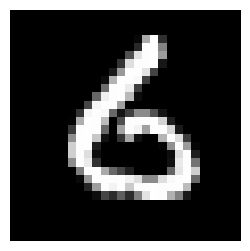

In [ ]:
show_images([x])

In [ ]:
# Let's now create a PyTorch DataLoader to prepare the training data
bs = 64
# just need image column of the dataset and ignore the labels
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

## Load model

In [ ]:
model_id = "openai/clip-vit-large-patch14"

clip = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id) # used to prepares input data to match the preprocessing steps

## Preprocessing Data

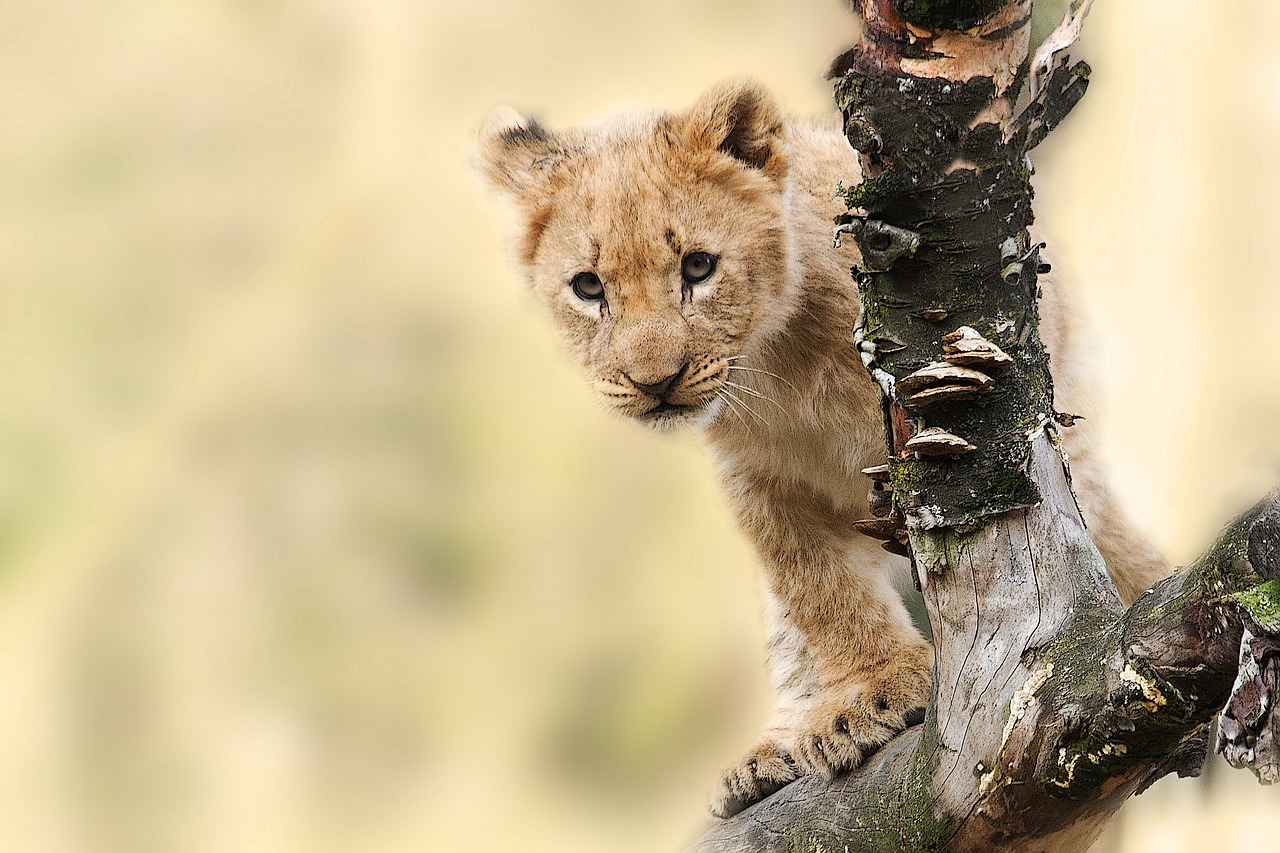

In [ ]:
url = SampleURL.LionExample
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# Let’s process the image first
image_inputs = processor(images=image, return_tensors="pt")
pixel_values = image_inputs["pixel_values"]

pixel_values.shape, pixel_values.min(), pixel_values.max()

(torch.Size([1, 3, 224, 224]), tensor(-1.7923), tensor(2.0179))

In [ ]:
processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

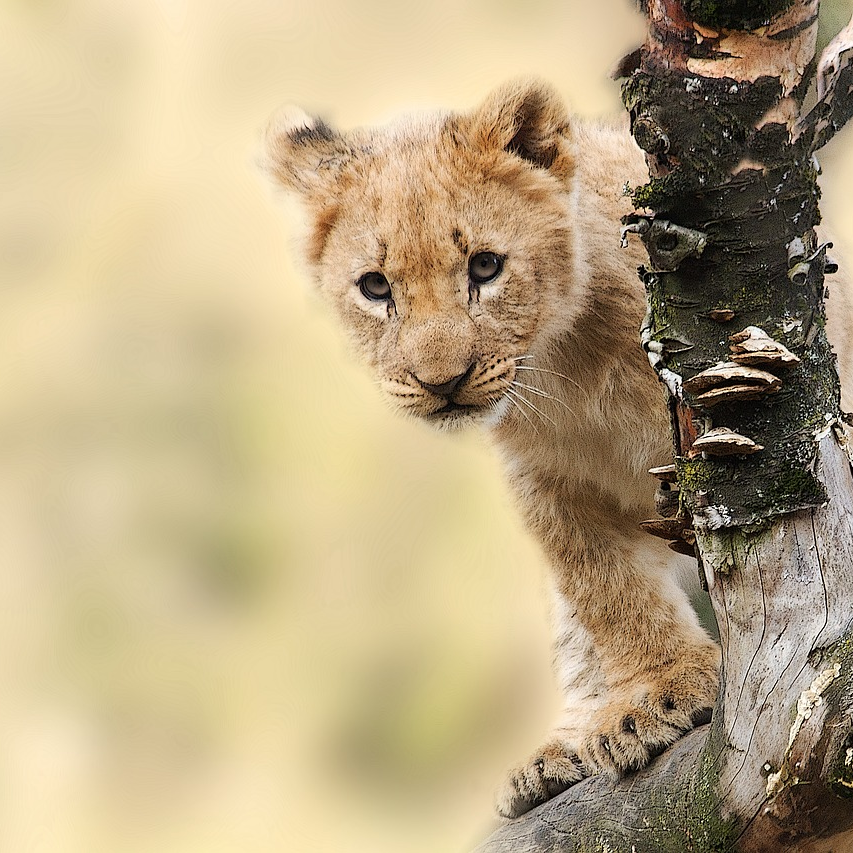

In [ ]:
# Let’s verify that our lion cub photo can survive a center crop
width, hieght = image.size
crop_length = min(image.size)

left = (width - crop_length) // 2
top = (hieght - crop_length) // 2
right = (width + crop_length) // 2
bottom = (hieght + crop_length) // 2

cropped = image.crop((left, top, right, bottom))
cropped

In [ ]:
# let's get the embedding vector from the preprocessed image
with torch.inference_mode():
  image_features = clip.vision_model(pixel_values.to(device))
image_embeddings = image_features.pooler_output
image_embeddings.shape

torch.Size([1, 1024])

## Image and Text Similiarity

In [ ]:
# let's compare the cosine similarity between the image embeddings and each prompt embedding
prompts = [
    "a photo of a lion",
    "a photo of a zebra"
]

# Padding makes sure all inputs have the same length
text_inputs = processor(text=prompts, padding=True, return_tensors="pt")
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  5567, 49407],
        [49406,   320,  1125,   539,   320, 22548, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

with torch.inference_mode():
  text_features = clip.text_model(**text_inputs)
text_embeddings = text_features.pooler_output
text_embeddings.shape

torch.Size([2, 768])

In [ ]:
# let's take arbitrary text and image encoders and compute a projection to vectors with the same dimensionality
print(clip.text_projection)
print(clip.visual_projection)
print(clip.text_projection.weight.shape)
print(clip.visual_projection.weight.shape)

Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=1024, out_features=768, bias=False)
torch.Size([768, 768])
torch.Size([768, 1024])


In [ ]:
with torch.inference_mode():
  text_embeddings = clip.text_projection(text_embeddings)
  image_embeddings = clip.visual_projection(image_embeddings)
text_embeddings.shape, image_embeddings.shape

(torch.Size([2, 768]), torch.Size([1, 768]))

In [ ]:
# let's compute the two dot products at once by using matrix multiplication
text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)

similarity = image_embeddings @ text_embeddings.T
# similarity = torch.matmul(image_embeddings, text_embeddings.T)
similarity

tensor([[0.2171, 0.1888]], device='cuda:0')

In [ ]:
# let's convert the scaled similarity logits to probabilities
similarities = 100 * torch.matmul(text_embeddings, image_embeddings.T)
similarities = similarities.softmax(dim=0).cpu()
similarities

tensor([[0.9441],
        [0.0559]])

## Zero-shot Image Classification

In [ ]:
model_id = "openai/clip-vit-large-patch14"
clip = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

In [5]:
image = Image.open(requests.get(SampleURL.LionExample, stream=True).raw)

In [6]:
# Let’s use a few more prompts to make things more fun
prompts = [
    "a photo of a lion",
    "a photo of a zebra",
    "a photo of a cat",
    "a photo of an adorable lion cub",
    "a puppy",
    "a lion behind a branch",
]

inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

outputs = clip(**inputs)
logits_per_image = outputs.logits_per_image
probabilities = logits_per_image.softmax(dim=1)

probabilities = probabilities[0].cpu().detach().tolist()

for prob, prompt in sorted(zip(probabilities, prompts), reverse=True):
  print(f"{100*prob: =2.0f}%: {prompt}")

89%: a photo of an adorable lion cub
 9%: a lion behind a branch
 2%: a photo of a lion
 0%: a photo of a zebra
 0%: a photo of a cat
 0%: a puppy


In [8]:
# let's abstract zero-shot image classification using pipeline
classifier = pipeline(
    "zero-shot-image-classification",
    model="openai/clip-vit-large-patch14",
    device=device,
)
"""
The pipeline takes care of all the details for us:
1-tokenization,
2-image preprocessing,
3-logits postprocessing
"""

Device set to use cuda


In [9]:
scores = classifier(
    image,
    candidate_labels=prompts,
    hypothesis_template="{}",
)
scores

[{'score': 0.8864128589630127, 'label': 'a photo of an adorable lion cub'},
 {'score': 0.09321879595518112, 'label': 'a lion behind a branch'},
 {'score': 0.018810098990797997, 'label': 'a photo of a lion'},
 {'score': 0.00111349206417799, 'label': 'a photo of a zebra'},
 {'score': 0.00041987316217273474, 'label': 'a photo of a cat'},
 {'score': 2.4912475055316463e-05, 'label': 'a puppy'}]